# Forest fire

This notebook presents an agent-based model that simulates a forest fire.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to work with a spatial grid and create animations, and perform a parameter sweep. 

In [6]:
# Model design
import agentpy as ap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython
import random

## About the model

The model ist based on the [NetLogo FireSimple model](http://ccl.northwestern.edu/netlogo/models/FireSimple) by Uri Wilensky and William Rand, who describe it as follows:

> "This model simulates the spread of a fire through a forest. It shows that the fire's chance of reaching the right edge of the forest depends critically on the density of trees. This is an example of a common feature of complex systems, the presence of a non-linear threshold or critical parameter. [...] 
>
> The fire starts on the left edge of the forest, and spreads to neighboring trees. The fire spreads in four directions: north, east, south, and west.
>
>The model assumes there is no wind. So, the fire must have trees along its path in order to advance. That is, the fire cannot skip over an unwooded area (patch), so such a patch blocks the fire's motion in that direction."

## Model definition

In [16]:
class LakeModel(ap.Model):
    
    def setup(self):
        
        # # Create agents (trees) 
        # n_trees = int(self.p['Tree density'] * (self.p.size**2))
        # trees = self.agents = ap.AgentList(self, n_trees)
        
        #Create agents (water)
        n_water = int(self.p['Water density'] * (self.p.size**2))
        water = self.agents = ap.AgentList(self, n_water)

        # # Create grid (forest)
        # self.forest = ap.Grid(self, [self.p.size]*2, track_empty=True)      
        # self.forest.add_agents(trees, random=True, empty=True)

        #Creacion lake
        self.lake = ap.Grid(self, [self.p.size]*2, track_empty=True)      
        self.lake.add_agents(water, random=True, empty=True)
        
        # # Initiate a dynamic variable for all trees
        # # Condition 0: Alive, 1: Burning, 2: Burned
        # self.agents.condition = 0 

        # Initiate a dynamic variable for all trees
        # Condition 0: Alive, 1: Evaporating, 2: Dry
        self.agents.condition = 0 
        
        # # Start a fire from the left side of the grid
        # unfortunate_trees = self.lake.agents[0:self.p.size, 0:2]
        # unfortunate_trees.condition = 1 

        # Start the drying process from specified coordinates
        start_x = self.p.get('start_x', 0)  # Default to 0 if not specified
        start_y = self.p.get('start_y', 0)  # Default to 0 if not specified
        spread_radius = self.p.get('initial_spread', 1)  # How many cells around the starting point
        
        # Validate coordinates are within grid bounds
        start_x = max(0, min(start_x, self.p.size - 1))
        start_y = max(0, min(start_y, self.p.size - 1))
        
        # Start drying from the specified coordinates with a small radius
        x_min = max(0, start_x - spread_radius)
        x_max = min(self.p.size, start_x + spread_radius + 1)
        y_min = max(0, start_y - spread_radius)  
        y_max = min(self.p.size, start_y + spread_radius + 1)
        
        unfortunate_water = self.lake.agents[x_min:x_max, y_min:y_max]
        unfortunate_water.condition = 1 
        
    def step(self):
    
        #********** WATER ***********

        #Se empieza a secar lagos aleatoriamente
        disaster_prob = 0.0001
        for water in self.agents.select(self.agents.condition == 0):
            if random.random() < disaster_prob:
                water.condition = 1
        
        # Select dry water
        dry_water = self.agents.select(self.agents.condition == 1)

        # Spread dry 
        for water in dry_water:
            for neighbor in self.lake.neighbors(water):
                if neighbor.condition == 0:
                    neighbor.condition = 1 # Neighbor starts burning
            water.condition = 2 # Water dry out  
        
        # Stop simulation if no fire is left
        if len(dry_water) == 0: 
            self.stop()

        #********** TREES ***********

        # #Se empiezan a incendiar arboles aleatoriamente por desastres naturales
        # disaster_prob = 0.0001
        # for tree in self.agents.select(self.agents.condition == 0):
        #     if random.random() < disaster_prob:
        #         tree.condition = 1

        # # Select burning trees
        # burning_trees = self.agents.select(self.agents.condition == 1)

        # # Spread fire 
        # for tree in burning_trees:
        #     for neighbor in self.forest.neighbors(tree):
        #         if neighbor.condition == 0:
        #             neighbor.condition = 1 # Neighbor starts burning
        #     tree.condition = 2 # Tree burns out  
        
        # # Stop simulation if no fire is left
        # if len(burning_trees) == 0: 
        #     self.stop()

        

            
    def end(self):
        # Document a measure at the end of the simulation
        dry_water = len(self.agents.select(self.agents.condition == 2))
        self.report('Percentage of burned trees', 
                    dry_water / len(self.agents))

        # # Document a measure at the end of the simulation
        # burned_trees = len(self.agents.select(self.agents.condition == 2))
        # self.report('Percentage of burned trees', 
        #             burned_trees / len(self.agents))

## Single-run animation

In [17]:
# Define parameters

# parameters = {
#     'Tree density': 0.6, # Percentage of grid covered by trees
#     'size': 50, # Height and length of the grid
#     'steps': 100,
# }

parameters = {
    # 'Tree density': 0.6, # Percentage of grid covered by tree
    'Water density': 0.6, # Percentage of grid covered by trees
    'size': 50, # Height and length of the grid
    'steps': 100,
    'start_x': 10, # Coordenada X donde inicia el fuego/secado (0 a size-1)
    'start_y': 25, # Coordenada Y donde inicia el fuego/secado (0 a size-1)
    'initial_spread': 1, # Radio inicial de propagación alrededor del punto de inicio
}

In [18]:
# Ejemplos de diferentes escenarios con coordenadas de inicio

# Escenario 1: Inicio en el centro
scenario_1 = {
    'Water density': 0.6,
    'size': 50,
    'steps': 100,
    'start_x': 25,  # Centro X
    'start_y': 25,  # Centro Y
    'initial_spread': 1,
}

# Escenario 2: Inicio en la esquina superior izquierda
scenario_2 = {
    'Water density': 0.6,
    'size': 50,
    'steps': 100,
    'start_x': 5,   # Cerca del borde izquierdo
    'start_y': 5,   # Cerca del borde superior
    'initial_spread': 2,
}

# Escenario 3: Inicio en la esquina inferior derecha
scenario_3 = {
    'Water density': 0.6,
    'size': 50,
    'steps': 100,
    'start_x': 45,  # Cerca del borde derecho
    'start_y': 45,  # Cerca del borde inferior
    'initial_spread': 1,
}

# Escenario 4: Inicio con propagación más amplia
scenario_4 = {
    'Water density': 0.6,
    'size': 50,
    'steps': 100,
    'start_x': 20,
    'start_y': 30,
    'initial_spread': 3,  # Área inicial más grande
}

# Escenario 5: Múltiples puntos de inicio simulando una línea
scenario_5 = {
    'Water density': 0.6,
    'size': 50,
    'steps': 100,
    'start_x': 0,   # Borde izquierdo
    'start_y': 25,  # Centro vertical
    'initial_spread': 0,  # Sin propagación inicial (solo un punto)
}

print("Escenarios disponibles:")
print("scenario_1: Inicio en el centro (25, 25)")
print("scenario_2: Inicio en esquina superior izquierda (5, 5)")
print("scenario_3: Inicio en esquina inferior derecha (45, 45)")
print("scenario_4: Inicio con propagación amplia (20, 30)")
print("scenario_5: Inicio en borde izquierdo (0, 25)")

Escenarios disponibles:
scenario_1: Inicio en el centro (25, 25)
scenario_2: Inicio en esquina superior izquierda (5, 5)
scenario_3: Inicio en esquina inferior derecha (45, 45)
scenario_4: Inicio con propagación amplia (20, 30)
scenario_5: Inicio en borde izquierdo (0, 25)


In [19]:
# Create single-run animation with custom colors

def animation_plot(model, ax):
    attr_grid = model.lake.attr_grid('condition')
    color_dict = {0:'#7FC97F', 1:'#d62c2c', 2:'#e5e5e5', None:'#d5e5d5'}
    ap.gridplot(attr_grid, ax=ax, color_dict=color_dict, convert=True)
    
    # Get starting coordinates from parameters
    start_x = model.p.get('start_x', 0)
    start_y = model.p.get('start_y', 0)
    
    ax.set_title(f"Simulación de secado de lago\n"
                 f"Tiempo: {model.t}, Agua restante: "
                 f"{len(model.agents.select(model.agents.condition == 0))}\n"
                 f"Inicio en coordenadas: ({start_x}, {start_y})")

# Usa uno de los escenarios definidos arriba, o define parámetros personalizados
# Cambiar 'parameters' por cualquiera de los escenarios: scenario_1, scenario_2, etc.
fig, ax = plt.subplots(figsize=(10, 8)) 
model = LakeModel(parameters)  # Cambiar por scenario_1, scenario_2, etc.
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml(fps=15))

## Cómo especificar las coordenadas de inicio

Ahora puedes especificar exactamente dónde quieres que comience el fuego/secado usando los siguientes parámetros:

- **`start_x`**: Coordenada X donde inicia (0 a size-1)
- **`start_y`**: Coordenada Y donde inicia (0 a size-1)  
- **`initial_spread`**: Radio inicial de propagación alrededor del punto de inicio

### Ejemplos de uso:

```python
# Para iniciar en una coordenada específica:
mis_parametros = {
    'Water density': 0.6,
    'size': 50,
    'steps': 100,
    'start_x': 30,  # Posición X deseada
    'start_y': 20,  # Posición Y deseada
    'initial_spread': 2,  # Área inicial
}

# Luego usar: model = LakeModel(mis_parametros)
```

### Escenarios predefinidos:
- Usa `scenario_1` para inicio en el centro
- Usa `scenario_2` para esquina superior izquierda
- Usa `scenario_3` para esquina inferior derecha
- Usa `scenario_4` para inicio con propagación amplia
- Usa `scenario_5` para inicio en borde izquierdo

NameError: name 'trees' is not defined

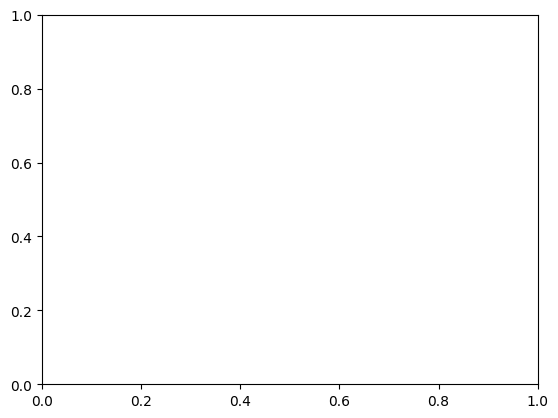

In [98]:
# Create single-run animation with custom colors

def animation_plot(model, ax):
    attr_grid = model.forest.attr_grid('condition')
    color_dict = {0:'#7FC97F', 1:'#d62c2c', 2:'#e5e5e5', None:'#d5e5d5'}
    ap.gridplot(attr_grid, ax=ax, color_dict=color_dict, convert=True)
    ax.set_title(f"Simulation of a forest fire\n"
                 f"Time-step: {model.t}, Trees left: "
                 f"{len(model.agents.select(model.agents.condition == 0))}")

fig, ax = plt.subplots() 
model = ForestModel(parameters)
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml(fps=15))

## Parameter sweep

In [5]:
# Prepare parameter sample
parameters = {
    'Tree density': ap.Range(0.2, 0.6), 
    'size': 100
}
sample = ap.Sample(parameters, n=30)

In [6]:
# Perform experiment
exp = ap.Experiment(ForestModel, sample, iterations=40)
results = exp.run()

Scheduled runs: 1200
Completed: 1200, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:01:59.829418


In [7]:
# Save and load data
results.save()
results = ap.DataDict.load('ForestModel')

Data saved to ap_output/ForestModel_1
Loading from directory ap_output/ForestModel_1/
Loading info.json - Successful
Loading parameters_constants.json - Successful
Loading parameters_log.json - Successful
Loading parameters_sample.csv - Successful
Loading reporters.csv - Successful


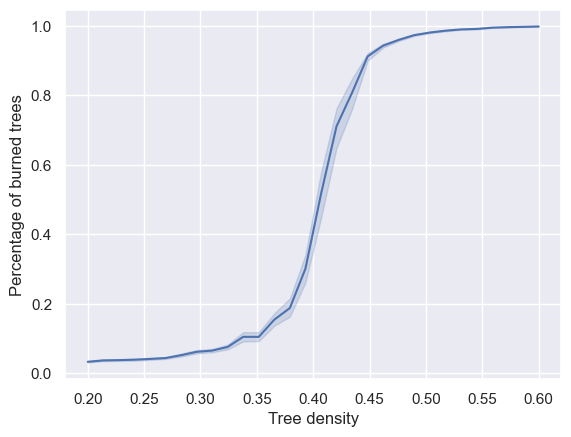

In [8]:
# Plot sensitivity
sns.set_theme()
sns.lineplot(
    data=results.arrange_reporters(), 
    x='Tree density', 
    y='Percentage of burned trees'
);